**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# ****Introduction

In this exercise, you will create predictions for a Kaggle competition. 

In [127]:
# Import helpful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA


from sklearn.model_selection import KFold
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings




warnings.filterwarnings('ignore')

# Load the data, and separate the target
train_data_path = '../input/train.csv'
train_data = pd.read_csv(train_data_path)
train_data = train_data.dropna(subset=['SalePrice'])
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.drop(columns=['Id'])
y_train_orig = pd.DataFrame(train_data.SalePrice)
X_train = train_data.drop('SalePrice', axis=1)


# path to file you will use for predictions
test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path)
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.drop(columns=['Id'])
test_data_orig = test_data.copy()

## Target value - SalePrice

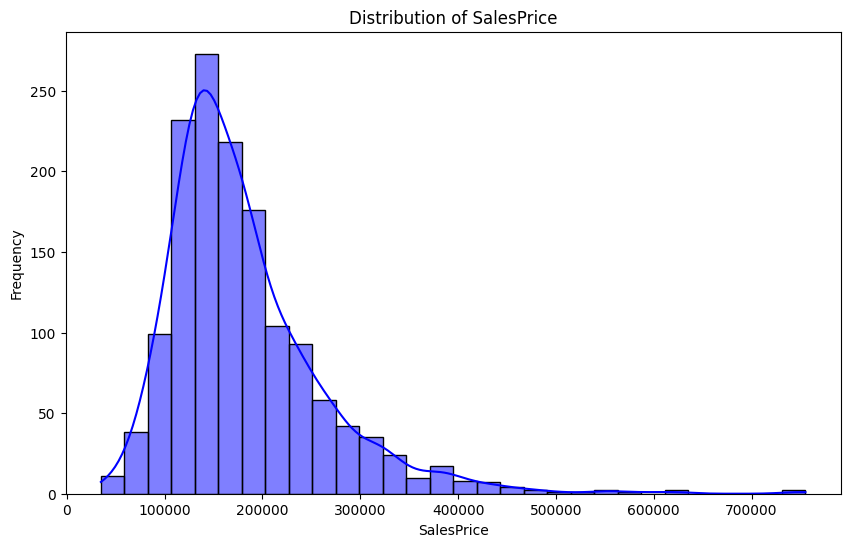

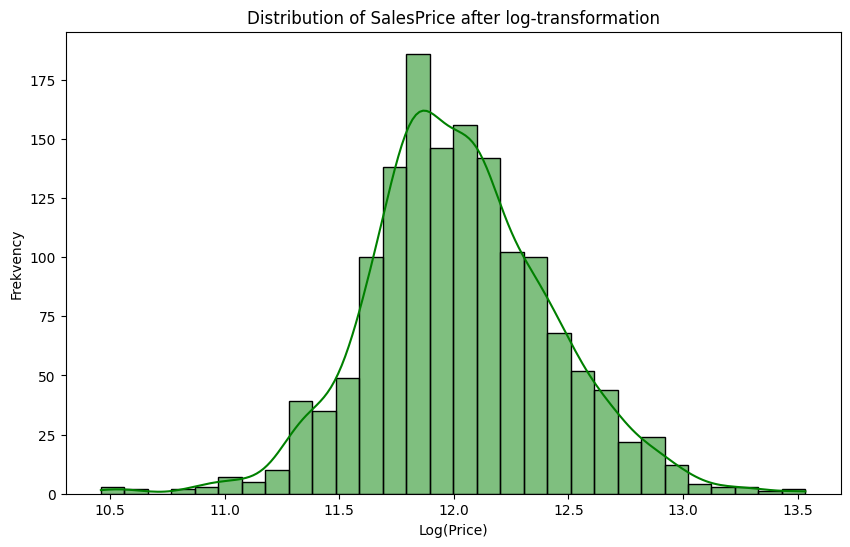

In [128]:
# First plot: Distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_train_orig['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalesPrice')
plt.xlabel('SalesPrice')
plt.ylabel('Frequency')
plt.show()

# Log transform the prices
#y_train = np.log(y_train['SalePrice'] + 1) # Add 1 to avoid log(0)
train_data['SalePrice'] = np.log(train_data['SalePrice'] + 1)

# Second plot: Distribution of log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='green')
plt.title('Distribution of SalesPrice after log-transformation')
plt.xlabel('Log(Price)')
plt.ylabel('Frekvency')
plt.show()

In [129]:
# Get column types
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Categorical columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

In [130]:
#Missing Values in these columns means that there is no available, not missing value --> replace NaN value by 'NA'

cat_cols_missing_by_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
train_data[cat_cols_missing_by_NA] = train_data[cat_cols_missing_by_NA].fillna('NA')



In [131]:
# Identify columns with high missing values ratio and drop it from train_data
cols_to_drop = []
cat_cols_high_missing_ratio = []
for col in train_data.columns:
    # If it contains a lot of missing values, we recommend dropping it
    missing_ratio = train_data[col].isnull().mean()
    if missing_ratio > 0.4:
        cat_cols_high_missing_ratio.append(col)
        cols_to_drop.append(col)

print(f"Columns that contains more than 40% missing values:", cat_cols_high_missing_ratio)

#for column in cat_cols_high_missing_ratio:
#    train_data.drop(columns=[column], inplace=True)               # ####################### VYMAZAT????

# Update numerical and categorical column lists
#numerical_cols = [col for col in numerical_cols if col not in cat_cols_high_missing_ratio]               # ####################### VYMAZAT????
#categorical_cols = [col for col in categorical_cols if col not in cat_cols_high_missing_ratio]           # ####################### VYMAZAT????

Columns that contains more than 40% missing values: ['MasVnrType']


## ADD NEW COLUMNS

In [132]:
# Defining new combined columns and their calculations
new_columns = {
    'TotalSF': lambda df: df['TotalBsmtSF'] + df['GrLivArea'],
    'TotalFlrSF': lambda df: df['1stFlrSF'] + df['2ndFlrSF'],
    'TotalPorchSF': lambda df: df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'],
    'TotalBathrooms': lambda df: df['FullBath'] + df['BsmtFullBath'] + 0.5 * (df['HalfBath'] + df['BsmtHalfBath'])
}

# Defining binary columns (boolean flags)
binary_columns = {
    'HasBasement': 'TotalBsmtSF',
    'HasGarage': 'GarageArea',
    'HasPorch': 'TotalPorchSF',
    'HasPool': 'PoolArea'
}

# Function to add new combined columns
def add_combined_columns(data, columns):
    for new_col, formula in columns.items():
        data[new_col] = formula(data)

# Function to add binary columns
def add_binary_columns(data, columns):
    for new_col, base_col in columns.items():
        data[new_col] = (data[base_col] > 0).astype(int)

# Apply to training and testing datasets
add_combined_columns(train_data, new_columns)


add_binary_columns(train_data, binary_columns)


# Update the list of categorical columns
categorical_cols = list(categorical_cols)
categorical_cols.extend(binary_columns.keys())

# Update the list of categorical columns
categorical_cols = list(categorical_cols)
categorical_cols.extend(binary_columns.keys())

# Update the list of numerical columns
numerical_cols = list(numerical_cols) + ['TotalSF', 'TotalFlrSF', 'TotalPorchSF', 'TotalBathrooms']

# CATEGORICAL COLUMNS

## Show distribution of values

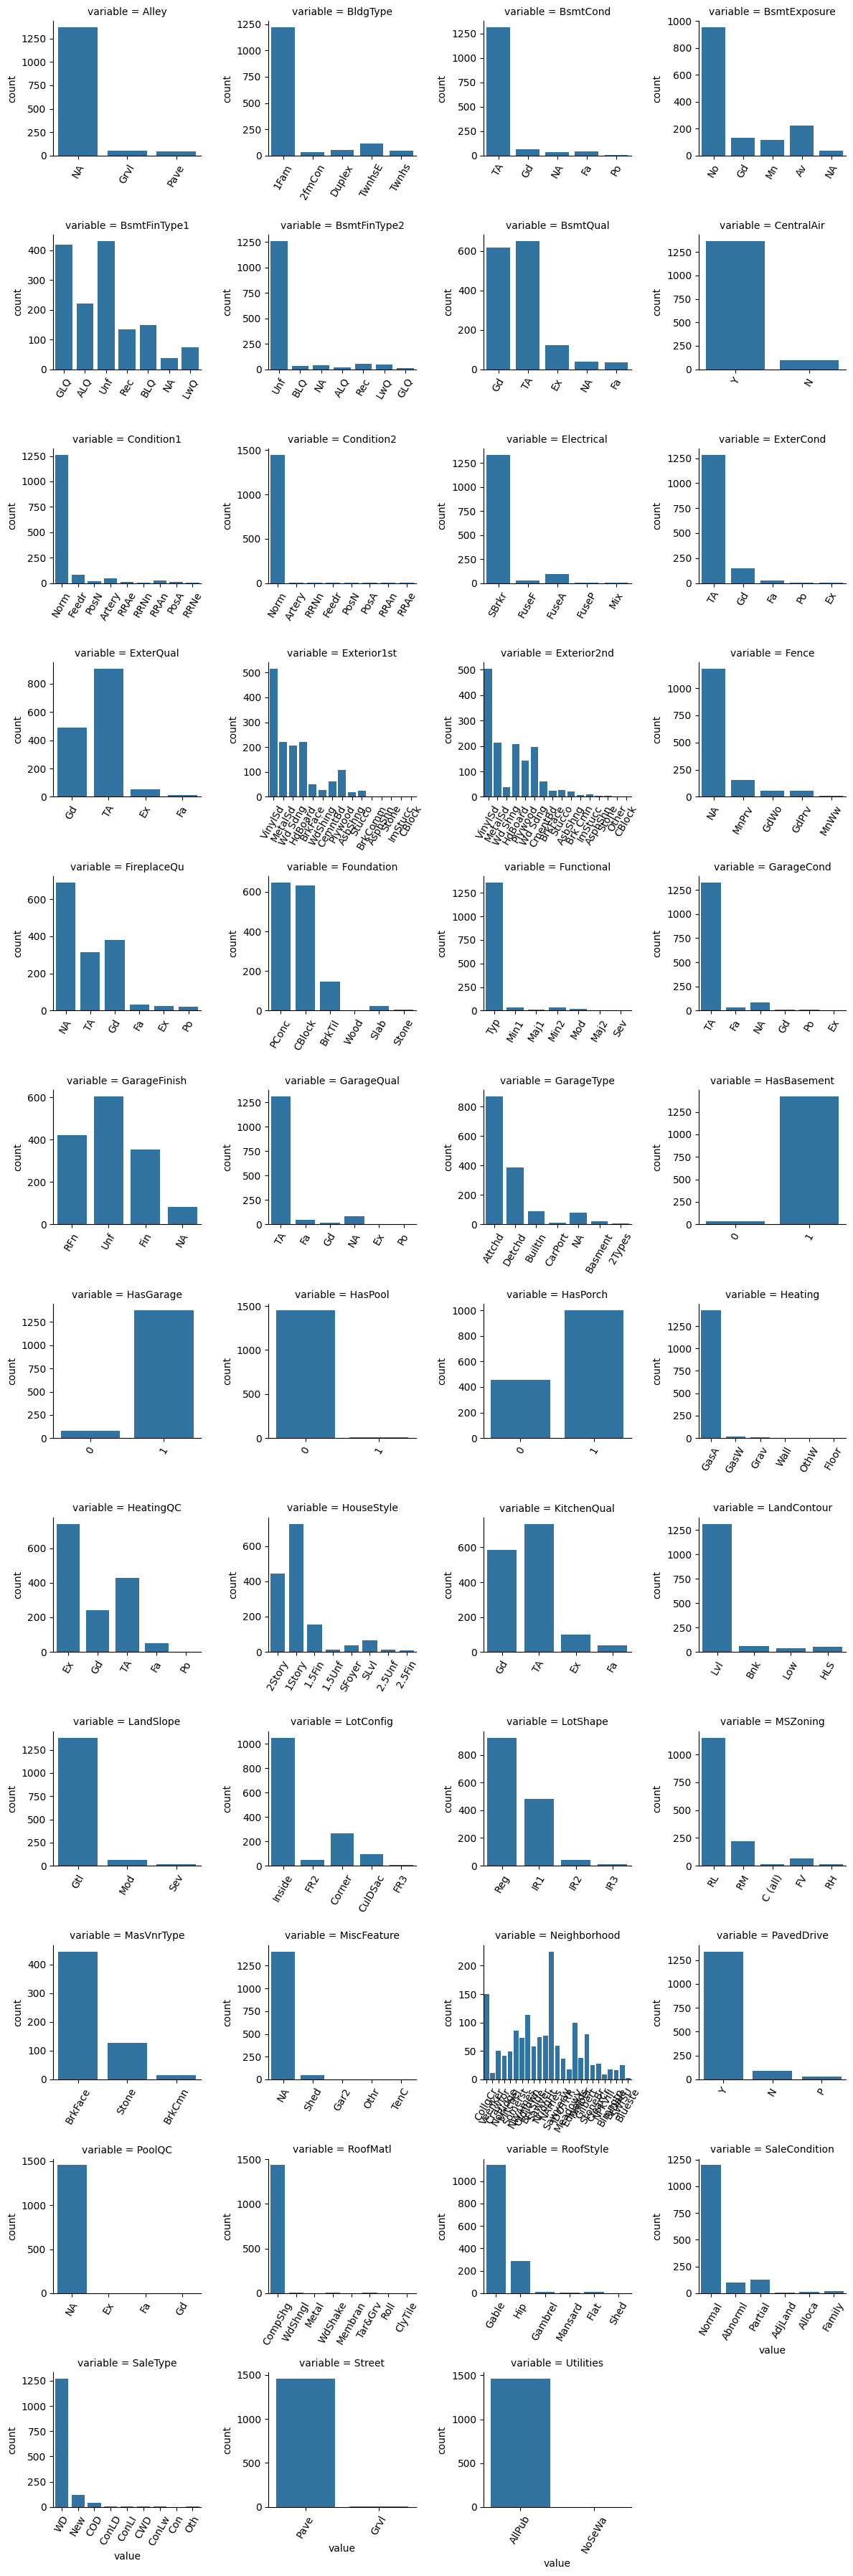

In [133]:
# Count plots of categorical features
f = pd.melt(train_data, value_vars=sorted(categorical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

## Show impact of categorical features on SalePrice

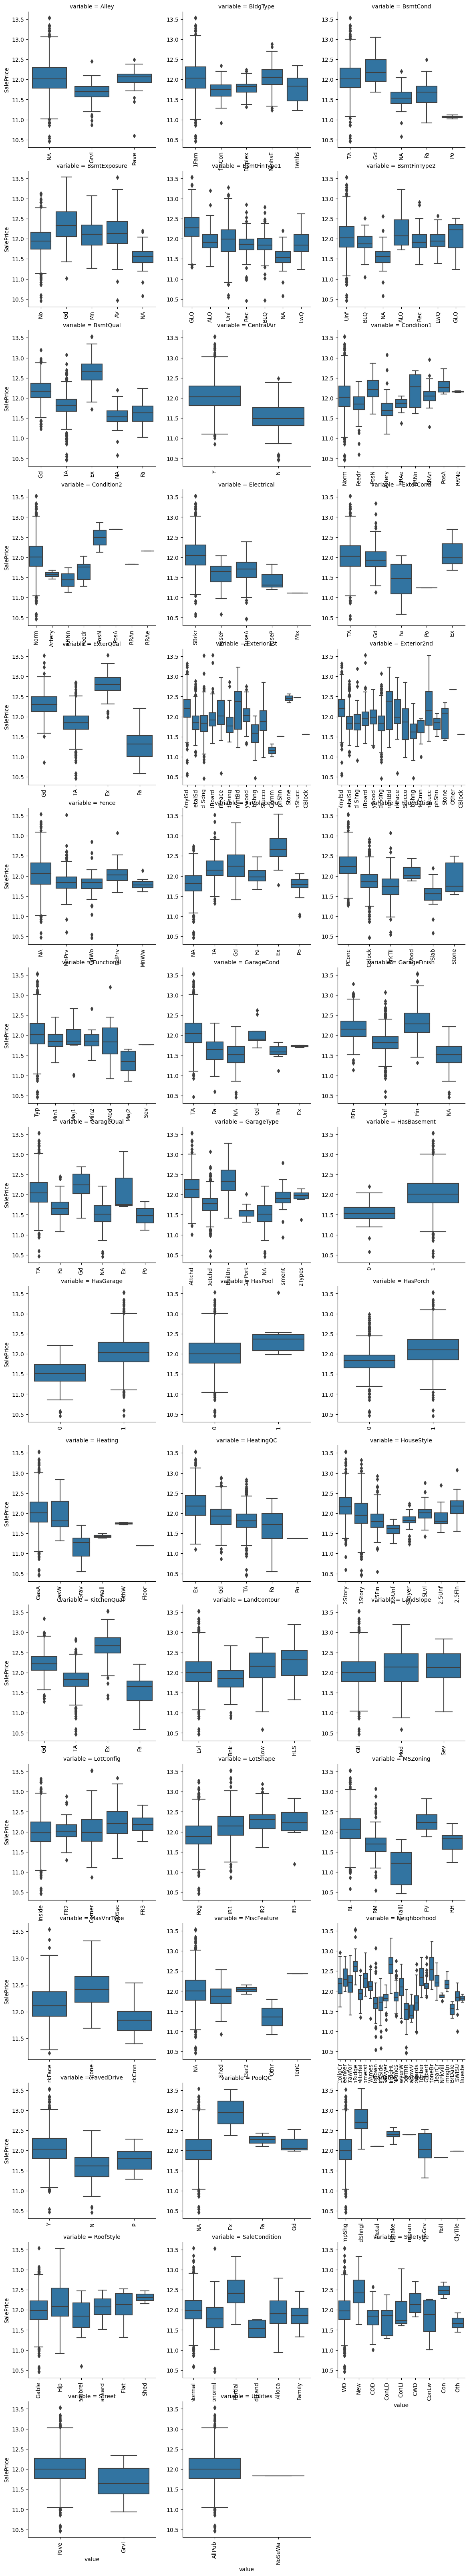

In [134]:
# Assuming train_data and categorical_cols are already defined
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(categorical_cols))

# Fix: Use 'height' instead of 'size'
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')

# Rotate the x-tick labels
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

plt.show()

## DROP IRRELEVANT COLUMNS

### CHECK IF CATEGORICAL COLUMNS UNIQUE VALUES ARE IN TEST DATA

In [135]:
# Check if all unique values in categorical columns in test_data are also in train_data
# (if any values are missing, the corresponding columns will be dropped)

columns_to_check = [col for col in categorical_cols if col not in ['HasBasement', 'HasGarage', 'HasPorch', 'HasPool']]
columns_missing_values = []

# Compare unique values for each column
for col in columns_to_check:
    unique_train = set(train_data[col].dropna().unique())  # Unique values in train_data (excluding NaN)
    unique_test = set(test_data[col].dropna().unique())  # Unique values in test_data (excluding NaN)
    
    if not unique_test.issubset(unique_train):  # If test_data has values missing in train_data
        columns_missing_values.append(col)
        cols_to_drop.append(col)

# Print columns that do not meet the condition
print(f"Columns in train_data that do not contain all unique values from test_data:", columns_missing_values)

Columns in train_data that do not contain all unique values from test_data: []


### CHECK IF ANY CATEGORICAL COLUMN DOES NOT CONTAIN LESS THAN 2 UNIQUE VALUES

In [136]:
# Identify columns with less than 2 unique values

cat_cols_few_unique_values = []
for col in categorical_cols:
    unique_values = train_data[col].nunique()
        
    # Check the number of unique values
    if unique_values < 2:
        cat_cols_few_unique_values.append(col)
        cols_to_drop.append(col)

print(f"Columns that contains less than 2 unique not NaN values:", cat_cols_few_unique_values)

Columns that contains less than 2 unique not NaN values: []


### CHECK SIGNIFICATION OF CATEGORICAL COLUMNS FOR SALEPRICE

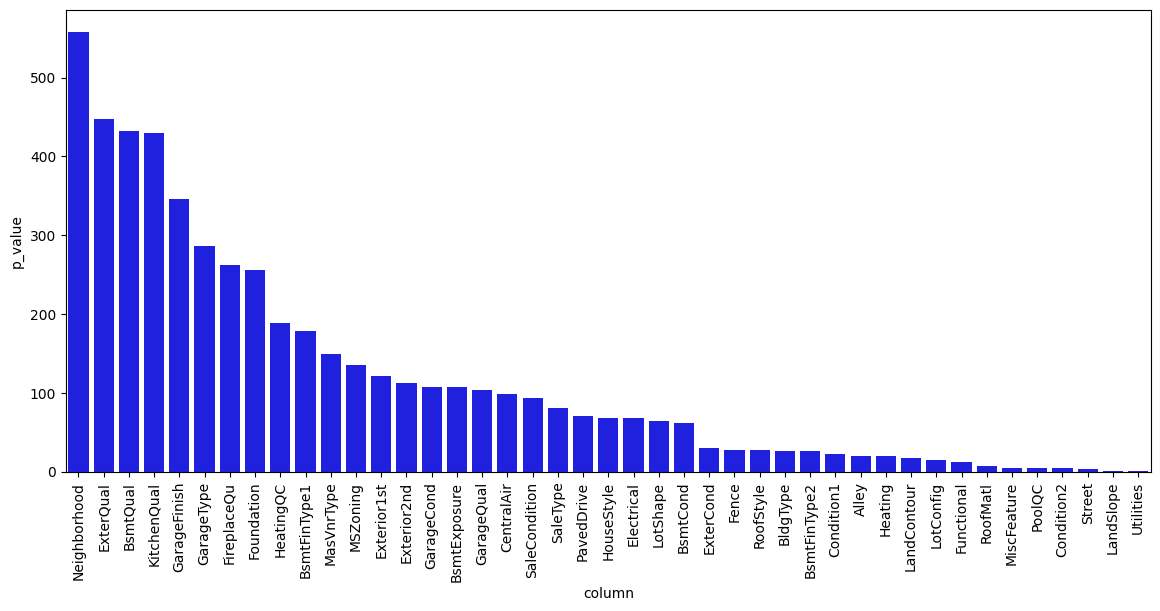

Columns without significant relation: ['LandSlope', 'Utilities']


In [137]:
# Target variable
target_column = 'SalePrice'  # Change this to the name of your target column

# Work with categorical columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

# Output dataframe for decision-making
evaluation_results = []

# Testing categorical columns
for col in categorical_cols:

    # Replace missing values
    train_data[col] = train_data[col].fillna('Missing')

    # For categorical vs numerical target: ANOVA
    if train_data[target_column].dtype in ['float64', 'int64']:

        groups = [train_data[target_column][train_data[col] == val] for val in train_data[col].unique()]
        f_stat, p_value = f_oneway(*groups)
        
        if p_value < 0.05:  # Significant relationship with the target variable
            evaluation_results.append({'column': col, 'reason': 'significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
        else:
            evaluation_results.append({'column': col, 'reason': 'no significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
    

train_data = train_data.replace('Missing', np.nan)

# Results as a dataframe
results_df = pd.DataFrame(evaluation_results)


results_df.sort_values('p_value', inplace=True)
results_df.reset_index(drop=True, inplace=True)
# Assuming 'results_df' is your DataFrame
plt.figure(figsize=(14,6))

# Fix: Use keyword arguments to specify x and y
sns.barplot(x=results_df['column'], y=np.log(1. / results_df['p_value']), color='blue')

# Rotate the x-tick labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

cat_cols_no_significant_relation = results_df[results_df['reason'] == 'no significant relation (ANOVA)']['column'].unique().tolist()
cols_to_drop = cols_to_drop + cat_cols_no_significant_relation

# Display decisions
print(f"Columns without significant relation:", cat_cols_no_significant_relation)

In [138]:
threshold = 0.95  # Set the threshold for dominance (e.g., 95%)

cat_cols_high_dominance = []
# Identify columns where one value dominates
for col in train_data.columns:
    dominant_ratio = train_data[col].value_counts(normalize=True).max()
    if dominant_ratio > threshold and col not in cat_cols_high_dominance:
        cat_cols_high_dominance.append(col)
        cols_to_drop.append(col)

# Display the results
print(f"Columns that have value with dominance more that 95%:", cat_cols_high_dominance)

Columns that have value with dominance more that 95%: ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'HasBasement', 'HasPool']


## ORDINAL ENCODING 

In [139]:
# Dictionary to define all categorical feature mappings for ordinal encoding
replacement_dicts = {
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},     # Excellent, Good, etc.
    'CentralAir': {'Y': 1, 'N': 0},  # Yes, No
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},  # Paved, Partial, Dirt/Gravel
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 0},  # Good, Average, etc.
    'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},  # Finished, Refined, Unfinished
    'Alley': {'Pave': 2, 'Grvl': 1, 'NA': 0},  # Paved, Gravel, No Alley
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},  # Regular, Irregular
    'LandContour': {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1},  # Level, Banked, Hillside, Low
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},  # AllPublic, NoSewer, etc.
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},  # Gentle, Moderate, Severe Slope
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},  # Functionality types
}

# Function to apply replacement to the specified columns of the data
def apply_replacement(data, columns, replacement_dicts):
    """
    Apply replacements to the columns based on the provided dictionary mappings.
    """
    for col in columns:
        if col in replacement_dicts:
            data[col] = data[col].replace(replacement_dicts[col])
    return data

# List of categorical columns to be encoded (if not all columns are required, customize this list)
categorical_cols_for_OrdinalEncoding = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'CentralAir', 'PavedDrive',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Alley', 'LotShape',
    'LandContour', 'Utilities', 'LandSlope', 'Functional'
]

categorical_cols_for_OrdinalEncoding = [col for col in categorical_cols_for_OrdinalEncoding if col not in cols_to_drop] ###### upravene

# Apply the replacements for both train and test datasets
train_data = apply_replacement(train_data, categorical_cols_for_OrdinalEncoding, replacement_dicts)


## ONE HOT ENCODING

In [140]:
# List of columns for One-Hot Encoding
categorical_cols_for_OHEncoding = ['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                                   'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Electrical', 'GarageType', 
                                   'Fence', 'SaleType', 'SaleCondition']
categorical_cols_for_OHEncoding = [col for col in categorical_cols_for_OHEncoding if col not in cols_to_drop] ###### upravene
# One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Transforming the training and test data using the same encoder
onehot_encoded_train_data = onehot_encoder.fit_transform(train_data[categorical_cols_for_OHEncoding])
### vzmayat   onehot_encoded_test_data = onehot_encoder.transform(test_data[categorical_cols_for_OHEncoding])

# Creating DataFrame for the encoded columns
onehot_encoded_train_data = pd.DataFrame(onehot_encoded_train_data, columns=onehot_encoder.get_feature_names_out(categorical_cols_for_OHEncoding))

# Checking the results by combining the encoded columns with the original data
train_data = pd.concat([train_data, onehot_encoded_train_data], axis=1)
### vzmayat   test_data = pd.concat([test_data[numerical_cols], test_data[categorical_cols_for_OrdinalEncoding], onehot_encoded_train_data], axis=1)
train_data.drop(columns=categorical_cols_for_OHEncoding, inplace=True)

# NUMERICAL COLUMNS

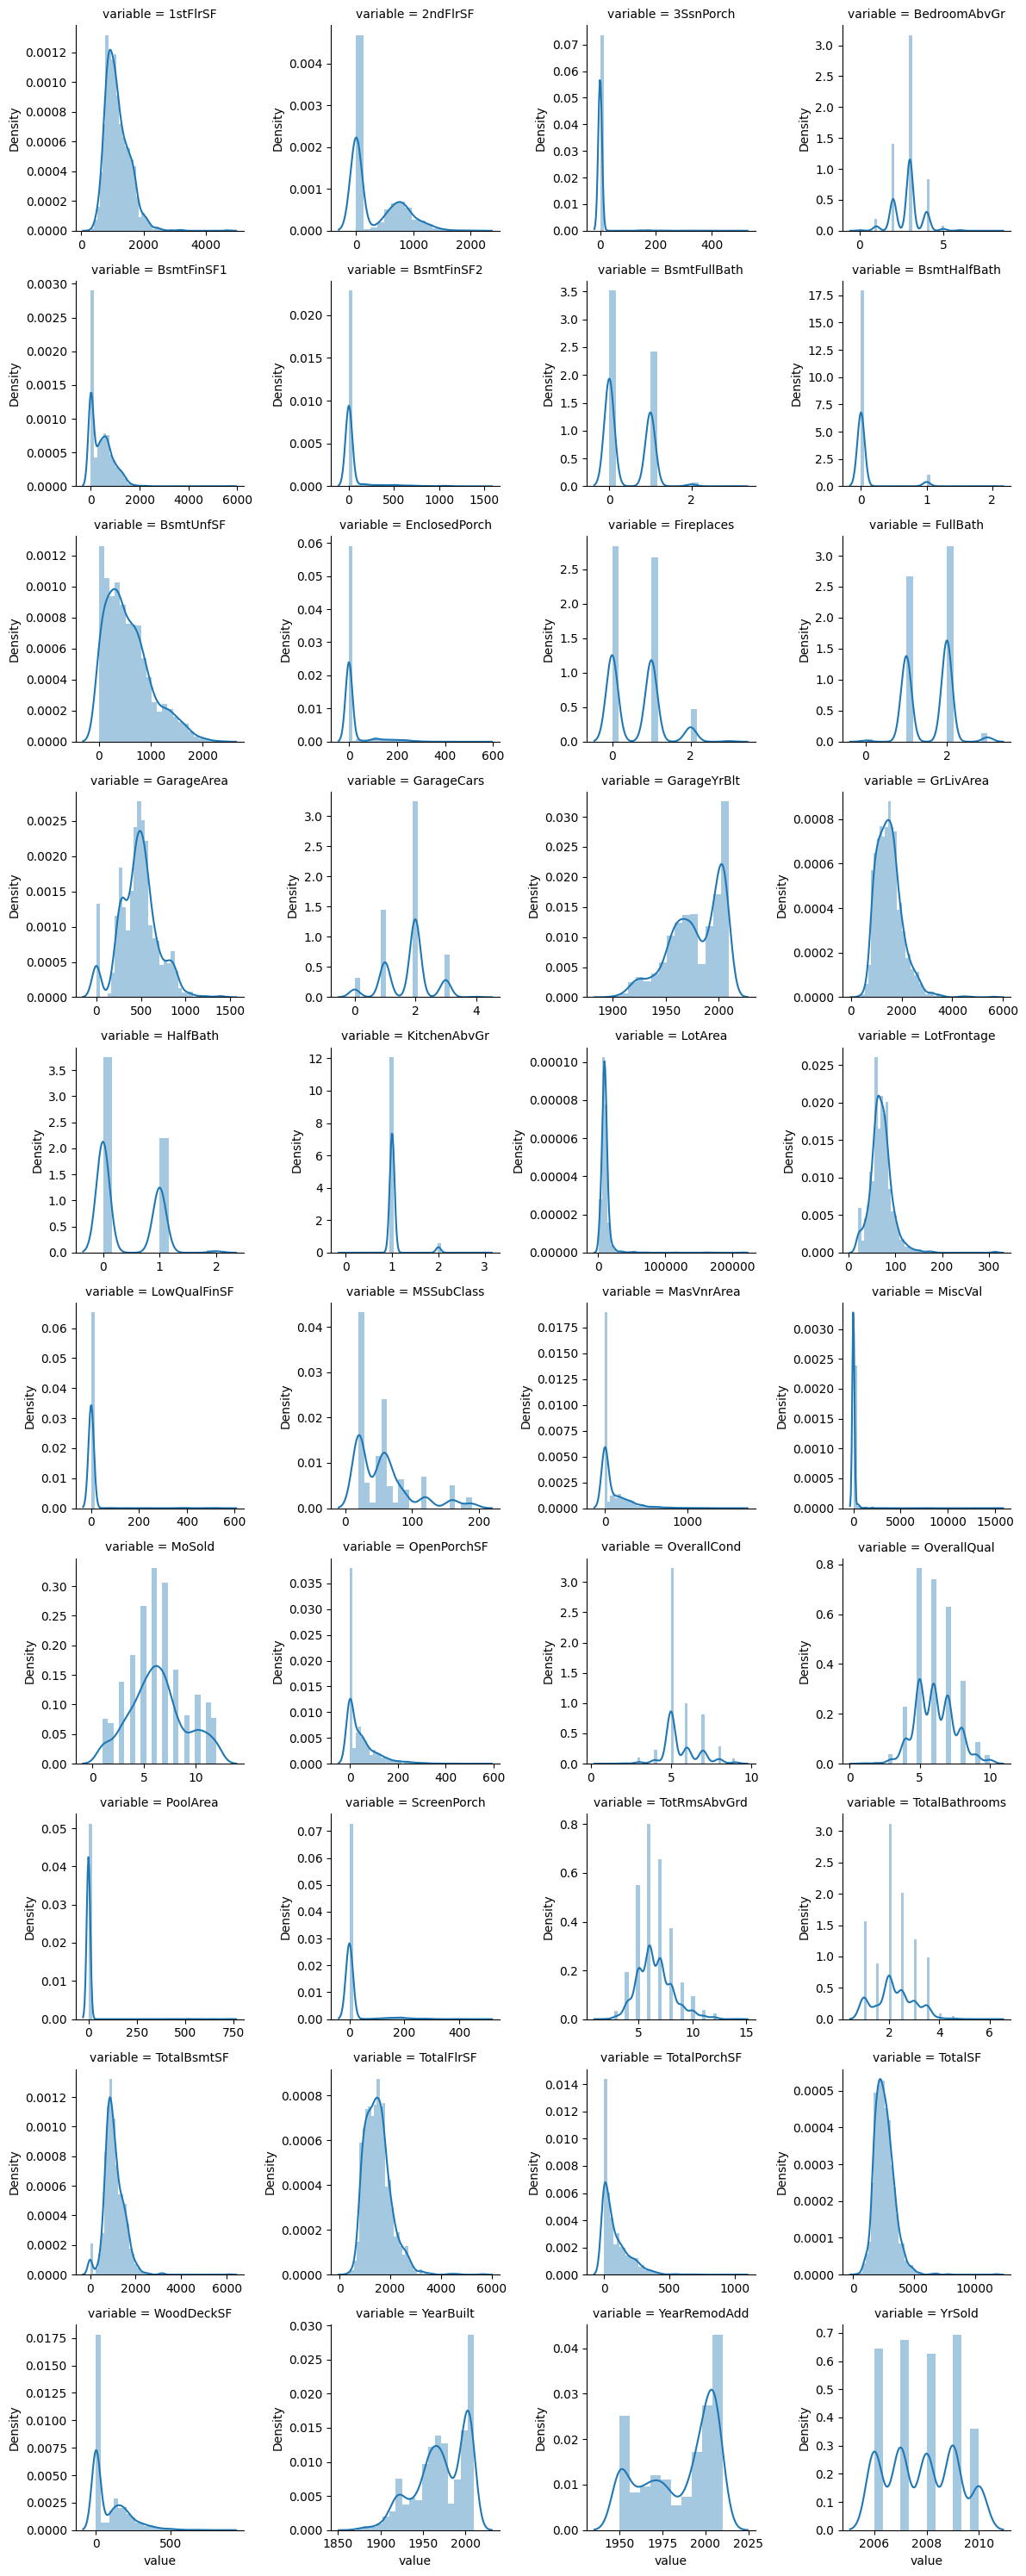

In [141]:
# Grid of distribution plots of all numerical features
f = pd.melt(train_data, value_vars=sorted(numerical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [142]:
train_data_num = train_data[numerical_cols]

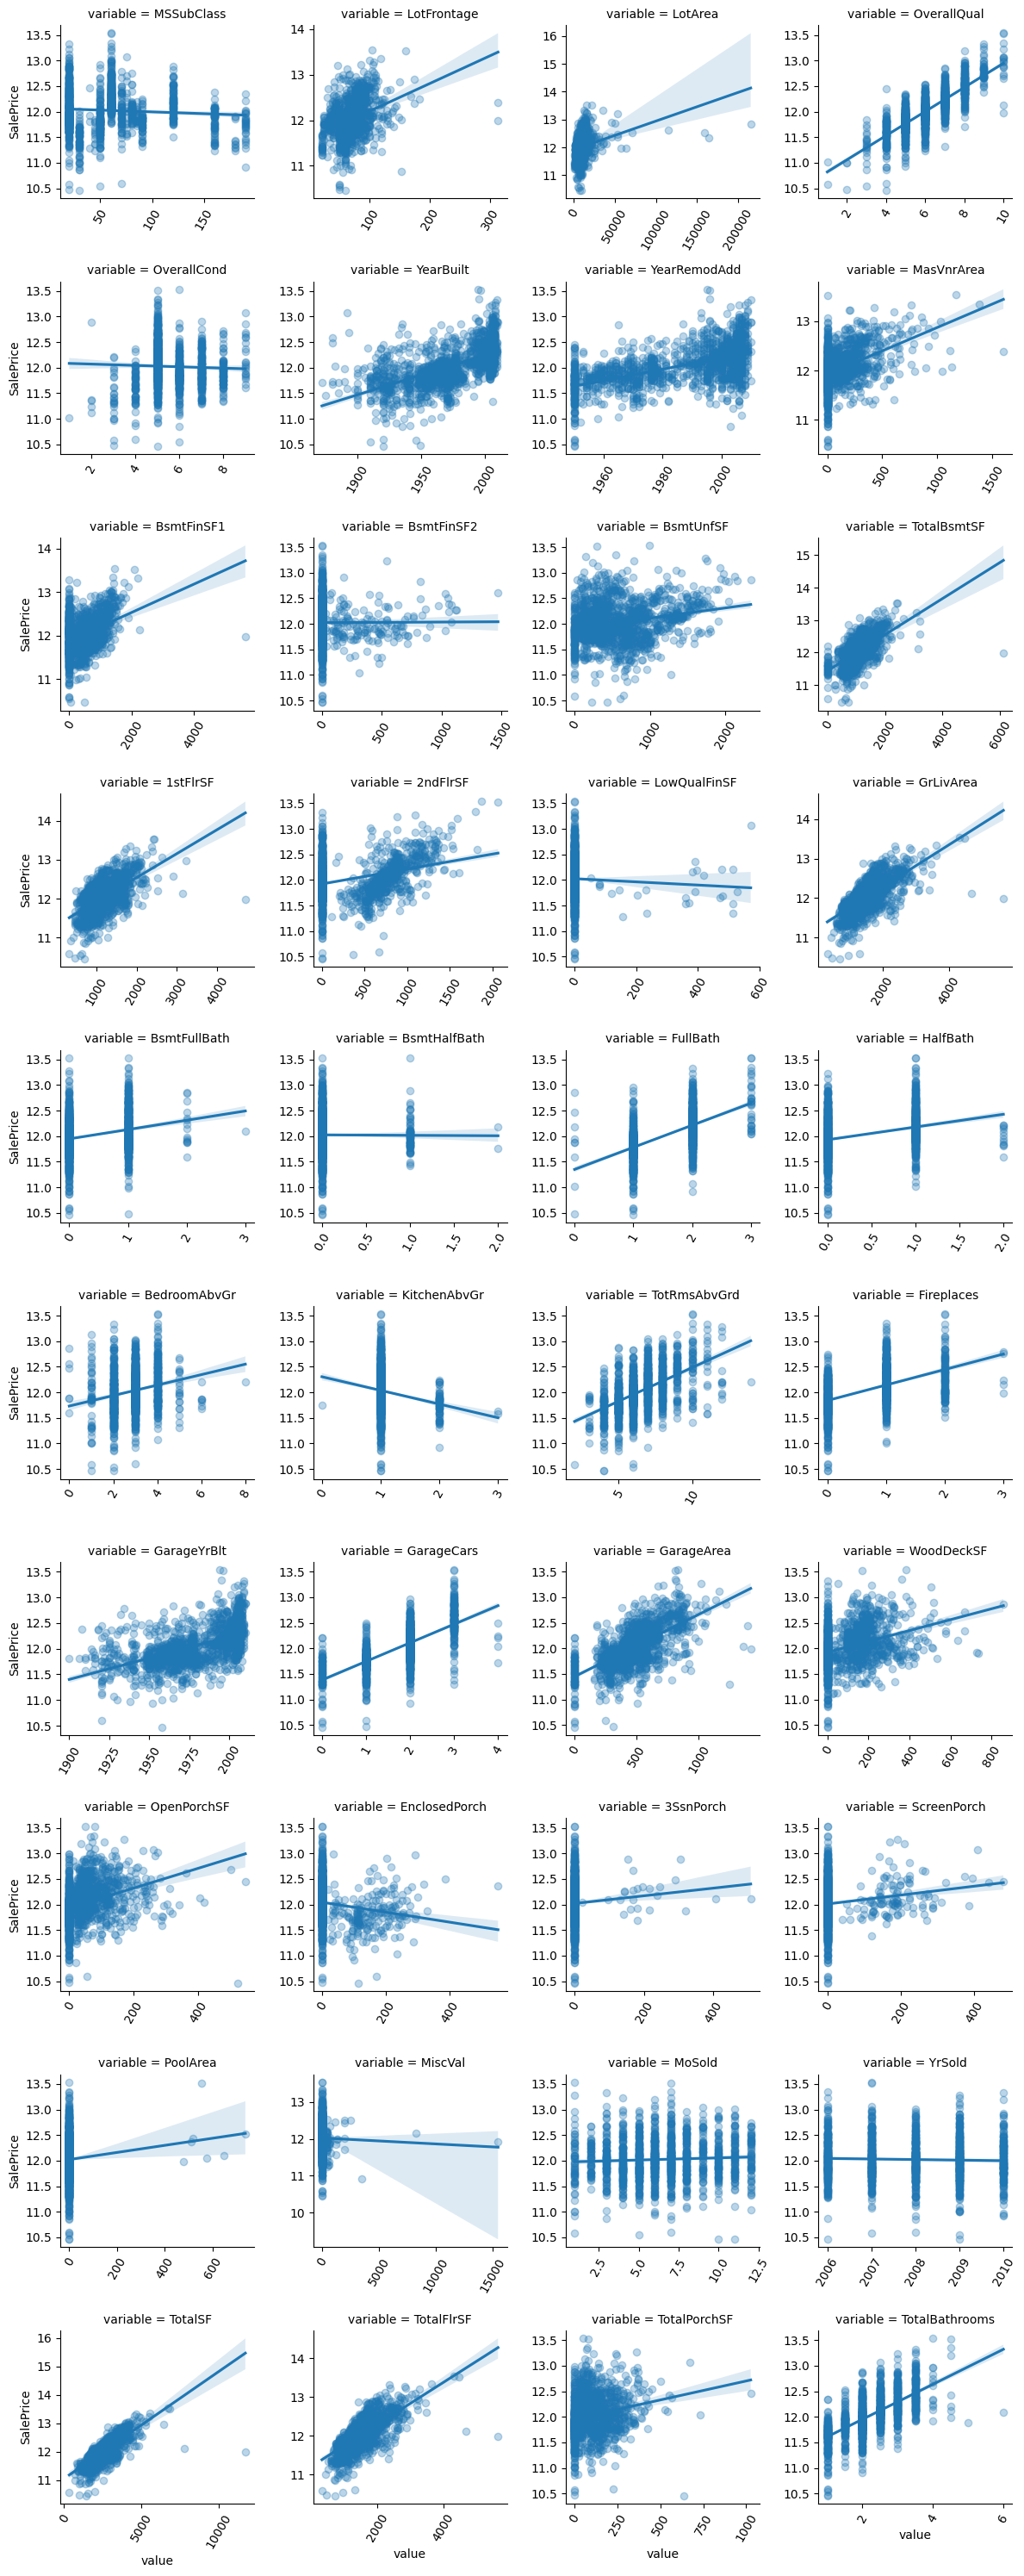

In [143]:
numerical_cols = [str(col) for col in numerical_cols]

# Scatter plots of numerical features against SalePrice
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=numerical_cols)

g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

['OverallQual', 'TotalSF', 'TotalFlrSF', 'GrLivArea', 'GarageCars', 'TotalBathrooms', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']


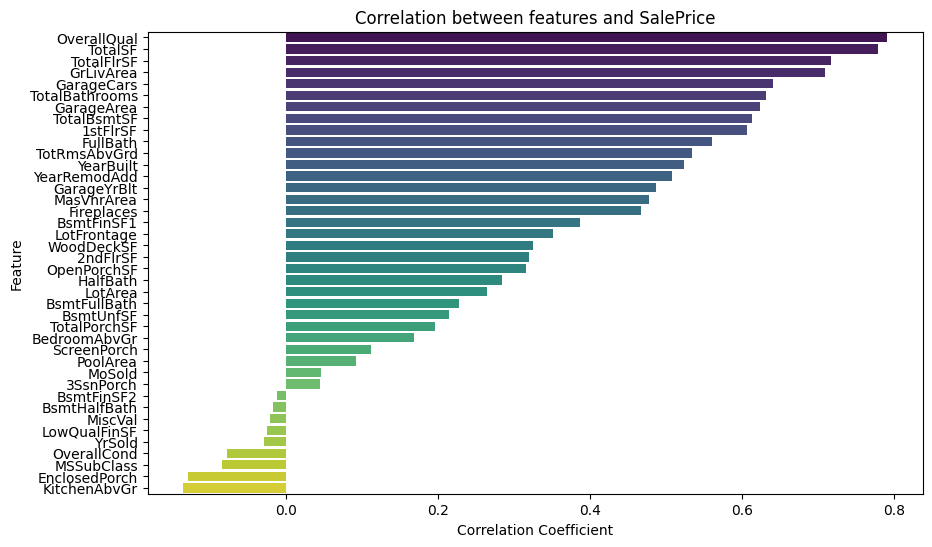

In [144]:

# Calculate correlation for each numerical feature with y
correlations = train_data[numerical_cols].corrwith(y_train_orig['SalePrice'])

# Sort results by value
correlations = correlations.sort_values(ascending=False)
# print(correlations)

# Select features with correlation > 0.6
numerical_cols_relevant = correlations[abs(correlations) > 0.6].index.tolist()
numerical_cols_irrelevant = correlations[abs(correlations) <= 0.6].index.tolist()
cols_to_drop = cols_to_drop + numerical_cols_irrelevant
print(numerical_cols_relevant)
# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")
plt.title("Correlation between features and SalePrice")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

Columns to drop due to strong correlations with each other: ['TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF', 'GarageYrBlt', '1stFlrSF', 'TotalFlrSF', 'GrLivArea']


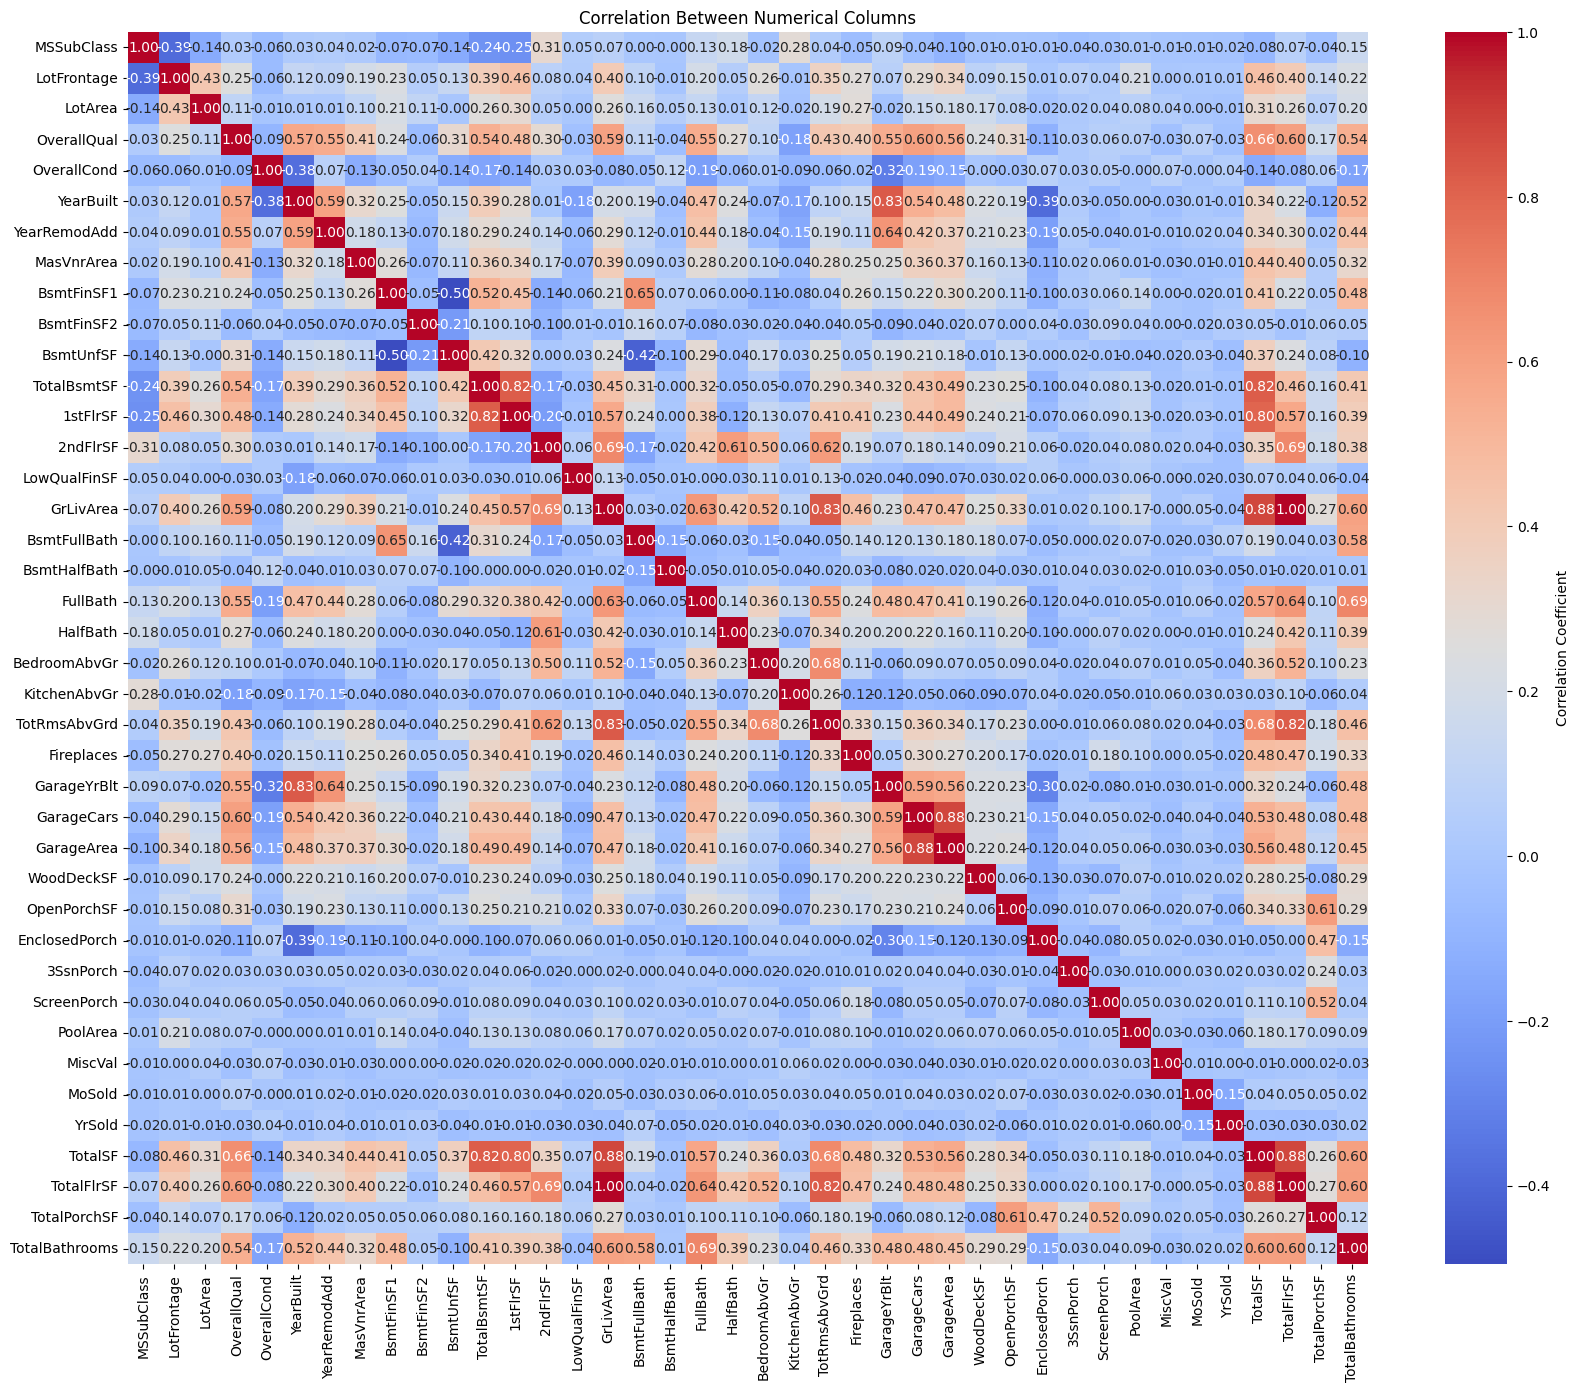

In [145]:
# Columns with high correlation between another numerical column but with smaller correlation with SalePrice than column1
num_cols_drop = []

# Calculate the correlation matrix
correlation_matrix = train_data[numerical_cols].corr()

# Set the threshold for strong correlation, e.g., 0.8 for strong correlations
threshold = 0.8

# Replace all values below the threshold with NaN
strong_correlation_matrix = correlation_matrix.applymap(lambda x: x if abs(x) >= threshold else np.nan)

# Set the diagonal to NaN to remove correlations between columns and themselves
np.fill_diagonal(strong_correlation_matrix.values, np.nan)

# Remove rows and columns that contain only NaN values
strong_correlation_matrix_clean = strong_correlation_matrix.dropna(how='all', axis=0)  # Remove rows with NaN
strong_correlation_matrix_clean = strong_correlation_matrix_clean.dropna(how='all', axis=1)  # Remove columns with NaN

# Iterate through pairs of columns with strong correlations
for col1 in range(len(strong_correlation_matrix_clean.columns)):
    for col2 in range(col1 + 1, len(strong_correlation_matrix_clean.columns)):
        # Get the column names
        col1_name = strong_correlation_matrix_clean.columns[col1]
        col2_name = strong_correlation_matrix_clean.columns[col2]

        # Correlation value between these columns
        correlation_value = strong_correlation_matrix_clean.loc[col2_name, col1_name]

        # Check if the correlation between columns is strong
        if abs(correlation_value) >= threshold and not np.isnan(correlation_value):
            # Correlations with SalePrice
            col1_corr_saleprice = abs(correlations[col1_name])
            col2_corr_saleprice = abs(correlations[col2_name])

            # Add the column with the lower correlation with SalePrice to the list
            if col1_corr_saleprice < col2_corr_saleprice:
                num_cols_drop.append(col1_name)
            else:
                num_cols_drop.append(col2_name)

# Remove duplicates, if any
num_cols_drop = list(set(num_cols_drop))
cols_to_drop = cols_to_drop + num_cols_drop

# Output the resulting list
print("Columns to drop due to strong correlations with each other:", num_cols_drop)

# Plot the correlation matrix heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Between Numerical Columns")
plt.show()

## DROP IRRELEVANT COLUMNS

In [146]:
train_data.drop(columns=cols_to_drop, inplace=True)
numerical_cols = [col for col in numerical_cols if col not in cols_to_drop]
categorical_cols_for_OrdinalEncoding = [col for col in categorical_cols_for_OrdinalEncoding if col not in cols_to_drop]

## REPLACING OF MISSING VALUES WITH KNN

In [147]:
train_data_y = train_data[['SalePrice']]
train_data = train_data.drop(columns=['SalePrice'])

# Initialize the KNN imputer (e.g., with 5 nearest neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the entire DataFrame (including numerical and encoded columns)
train_data_imputed = pd.DataFrame(knn_imputer.fit_transform(train_data), columns=train_data.columns)
#test_data_imputed = pd.DataFrame(knn_imputer.transform(test_data), columns=train_data.columns)

## STANDARDIZING 

In [148]:
# Common columns for standardization
cols_to_standardize = list(numerical_cols) + categorical_cols_for_OrdinalEncoding
#cols_to_standardize = list(set(numerical_cols + categorical_cols_for_OrdinalEncoding))

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization only to numerical and ordinal columns
train_data_imputed[cols_to_standardize] = scaler.fit_transform(train_data_imputed[cols_to_standardize])
#test_data_imputed[cols_to_standardize] = scaler.transform(test_data_imputed[cols_to_standardize])

In [149]:
train_data_imputed

Alley  LotShape  LandContour  OverallQual  ExterQual  ExterCond  \
0    -0.243025  0.701291     0.306146     0.651479   1.052302  -0.238112   
1    -0.243025  0.701291     0.306146    -0.071836  -0.689604  -0.238112   
2    -0.243025 -1.016637     0.306146     0.651479   1.052302  -0.238112   
3    -0.243025 -1.016637     0.306146     0.651479  -0.689604  -0.238112   
4    -0.243025 -1.016637     0.306146     1.374795   1.052302  -0.238112   
...        ...       ...          ...          ...        ...        ...   
1455 -0.243025  0.701291     0.306146    -0.071836  -0.689604  -0.238112   
1456 -0.243025  0.701291     0.306146    -0.071836  -0.689604  -0.238112   
1457 -0.243025  0.701291     0.306146     0.651479   2.794208   2.611429   
1458 -0.243025  0.701291     0.306146    -0.795151  -0.689604  -0.238112   
1459 -0.243025  0.701291     0.306146    -0.795151   1.052302  -0.238112   

      BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  ...  SaleType_ConLI  \
0     0.583168  0.117884     -0.540602      1.169860  ...             0.0   
1     0.583168  0.117884      2.144022      0.698038  ...             0.0   
2     0.583168  0.117884      0.354272      1.169860  ...             0.0   
3    -0.558153  1.929579     -0.540602      0.698038  ...             0.0   
4     0.583168  0.117884      1.249147      1.169860  ...             0.0   
...        ...       ...           ...           ...  ...             ...   
1455  0.583168  0.117884     -0.540602     -1.189250  ...             0.0   
1456  0.583168  0.117884     -0.540602      0.698038  ...             0.0   
1457 -0.558153  1.929579     -0.540602      1.169860  ...             0.0   
1458 -0.558153  0.117884      0.354272      1.169860  ...             0.0   
1459 -0.558153  0.117884     -0.540602      0.226216  ...             0.0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0                0.0           0.0           0.0          1.0   
1                0.0           0.0           0.0          1.0   
2                0.0           0.0           0.0          1.0   
3                0.0           0.0           0.0          1.0   
4                0.0           0.0           0.0          1.0   
...              ...           ...           ...          ...   
1455             0.0           0.0           0.0          1.0   
1456             0.0           0.0           0.0          1.0   
1457             0.0           0.0           0.0          1.0   
1458             0.0           0.0           0.0          1.0   
1459             0.0           0.0           0.0          1.0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                       0.0                   0.0                   0.0   
1                       0.0                   0.0                   0.0   
2                       0.0                   0.0                   0.0   
3                       0.0                   0.0                   0.0   
4                       0.0                   0.0                   0.0   
...                     ...                   ...                   ...   
1455                    0.0                   0.0                   0.0   
1456                    0.0                   0.0                   0.0   
1457                    0.0                   0.0                   0.0   
1458                    0.0                   0.0                   0.0   
1459                    0.0                   0.0                   0.0   

      SaleCondition_Normal  SaleCondition_Partial  
0                      1.0                    0.0  
1                      1.0                    0.0  
2                      1.0                    0.0  
3                      0.0                    0.0  
4                      1.0                    0.0  
...                    ...                    ...  
1455                   1.0                    0.0  
1456                   1.0                    0.0  
1457                 

## MUTUAL INFORMATION

In [150]:
# Calculate mutual information between input columns and the target variable
mi = mutual_info_classif(train_data_imputed, y_train_orig)

# Create a DataFrame to display column names and their MI values
mi_df = pd.DataFrame({
    'Feature': train_data_imputed.columns,  # Column names
    'Mutual Information': mi  # Mutual information values
})

# Display the DataFrame
# print(mi_df)

Selected features based on MI:  ['Alley', 'LotShape', 'LandContour', 'OverallQual', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'HasGarage', 'HasPorch', 'MSZoning_RL', 'LotConfig_Inside', 'Condition1_Norm', 'RoofStyle_Gable', 'Electrical_SBrkr', 'GarageType_Attchd', 'Fence_NA', 'SaleType_WD', 'SaleCondition_Normal']


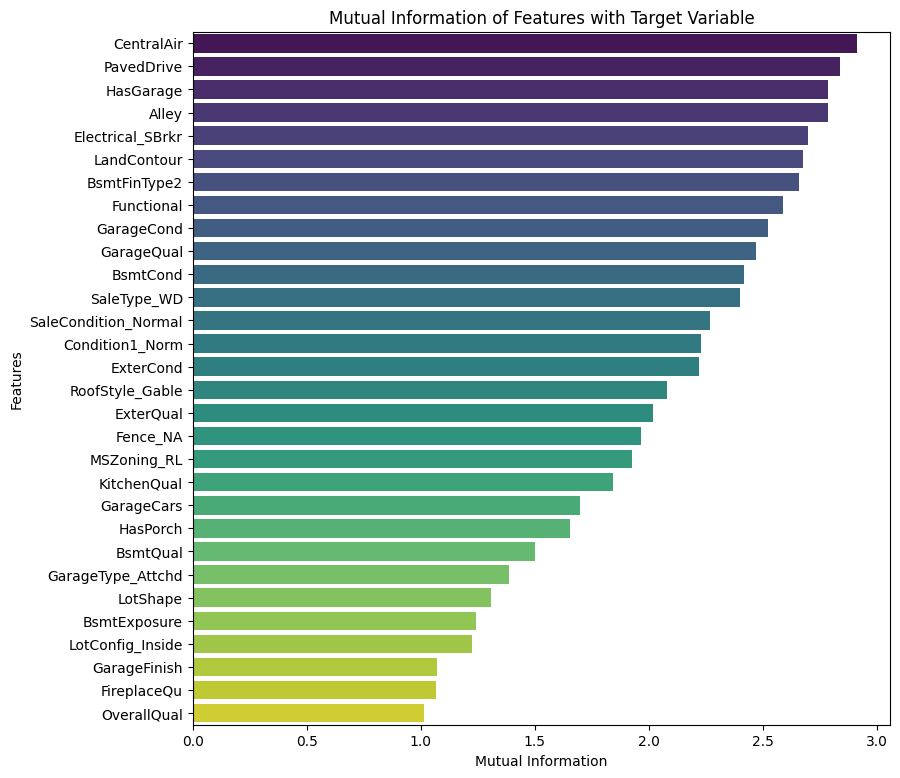

In [151]:
# Setting a threshold below which columns will be removed (e.g., 0.1)
threshold = 1

# Selecting columns with MI greater than the specified threshold
selected_features = mi_df[mi_df['Mutual Information'] > threshold]

# List of selected columns
selected_columns = selected_features['Feature'].tolist()

print("Selected features based on MI: ", selected_columns)

# Create a plot
plt.figure(figsize=(9, 9))
sns.barplot(
    x='Mutual Information', 
    y='Feature', 
    data=selected_features.sort_values(by='Mutual Information', ascending=False), 
    palette='viridis'
)
plt.title('Mutual Information of Features with Target Variable')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

train_data_imputed = train_data_imputed[selected_columns]

In [152]:
final_columns = train_data_imputed.columns.tolist()

In [153]:
# Select only the specified columns
train_data_imputed = train_data_imputed[selected_columns]
# print(train_data_imputed)

# 4. Apply PCA
pca = PCA()
pca_components = pca.fit_transform(train_data_imputed)

# 5. Variance explained by the principal components
explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained variance ratio:", explained_variance_ratio)

# 6. Retain only components that explain 95% of the variance
cumulative_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # First n components
# print(f"Number of components for 95% variance: {num_components}")

# PCA with the optimal number of components
pca_optimal = PCA(n_components=num_components)
reduced_data = pca_optimal.fit_transform(train_data_imputed)

# 7. Result as a new DataFrame
pca_columns = [f'PC{i+1}' for i in range(num_components)]
df_pca = pd.DataFrame(reduced_data, columns=pca_columns)

In [154]:
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.097827 -0.031977  0.583899 -1.086430 -0.390584  0.072670 -0.485862   
1    -0.656813 -0.115928 -1.044567  0.168207  0.099944 -0.121560 -1.156831   
2    -1.869311  0.501017  0.293930  0.163538 -0.379704 -0.319614  0.047099   
3    -1.264656 -0.110069 -0.261021 -0.033434  0.090573 -0.245201  0.103161   
4    -2.737805  0.723863  0.357163  0.457380 -0.130526 -0.231552 -0.040575   
...        ...       ...       ...       ...       ...       ...       ...   
1455 -0.223380 -0.733747 -0.042380 -0.414878 -0.319428 -0.172178 -0.712684   
1456  0.356517 -0.962004 -0.924759  0.332994 -0.910774  2.067171  0.234872   
1457 -1.731959  0.339467 -0.417453 -1.992283 -0.293350 -0.508058  2.366660   
1458  0.959571 -0.760264 -1.322923 -0.304558 -0.439671  1.135248  0.158879   
1459  0.287790 -0.866969  0.079723 -0.716947 -0.470028 -0.224108 -0.693282   

           PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0     0.002249 -0.225146  0.061264 -1.008641  0.468403  0.807693 -0.134016   
1    -0.051338 -1.032246 -0.297449  0.755006 -0.310596 -1.717075 -0.079702   
2    -0.135035  0.624346 -0.207069 -0.026191  0.016684 -0.207463  0.316108   
3     0.123299  1.047261 -0.323197  1.105890 -0.418789  0.594995  1.861196   
4    -0.271569  0.249527 -0.416463 -0.234929  0.079171 -0.855697  0.782392   
...        ...       ...       ...       ...       ...       ...       ...   
1455  0.052125 -0.167315  0.010890  1.090887 -0.373848  0.284375 -0.433925   
1456 -0.163058 -0.309927  0.399748  0.865025 -0.434327  0.507474  0.476379   
1457  1.093829 -0.571284 -0.219320  0.503191 -0.521545  0.905519 -0.252411   
1458 -1.124780 -0.606529  0.838068 -0.734704  0.315919  0.008341  0.469090   
1459 -0.126409  0.007756 -0.054528 -0.506020  0.447479  0.361213 -1.757239   

          PC15      PC16      PC17      PC18      PC19      PC20  
0    -0.118168  0.321883 -0.118523 -0.026934 -0.496602 -0.076288  
1     0.457333  0.059312 -0.099572 -0.132662 -0.082232  0.112486  
2    -0.438162  0.232442  0.187358 -0.170030 -0.471080 -0.054338  
3     0.923318 -1.374266 -0.264024  1.088097  0.586880 -0.639985  
4     0.694681  0.157067 -0.184698  0.312543 -0.400674 -0.390132  
...        ...       ...       ...       ...       ...       ...  
1455  0.539873  0.042326 -0.117711 -0.571695 -0.370483 -0.128927  
1456  0.674379  0.217277 -0.216383 -0.642439 -0.211755  0.694214  
1457 -1.607394  0.919951  1.103389  1.637122 -0.287814 -0.131130  
1458 -1.143665 -0.382385 -0.452028  0.083831 -0.139521  0.184158  
1459 -0.897198  0.729413  0.907851  0.653719 -0.371534 -0.356317  

[1460 rows x 20 columns]

In [155]:
# Assuming X and y are defined
X = df_pca.reset_index(drop=True)  # Reset index in X
y = train_data_y.reset_index(drop=True)  # Reset index in y

# 1. Define a function to evaluate the model
def objective(params):
    # Set up K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_mse = []
    
    # XGBoost model with parameters
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_alpha=params['reg_alpha'],  # L1 regularization
            reg_lambda=params['reg_lambda'],  # L2 regularization
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    # Average MSE across all folds
    mean_mse = np.mean(fold_mse)
    return {'loss': mean_mse, 'status': STATUS_OK}

# 2. Hyperparameter space
param_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
    'subsample': hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),  # L1 regularization (log space)
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))  # L2 regularization (log space)
}

# 3. Optimization
trials = Trials()
best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=50,  # Number of combinations
    trials=trials
)

# 4. Results
print("Best parameters:", best_params)

100%|██████████| 50/50 [02:13<00:00,  2.66s/trial, best loss: 0.03668708605646802] 
Best parameters: {'colsample_bytree': 0.9208259408822224, 'learning_rate': 0.04873010856467637, 'max_depth': 3.0, 'n_estimators': 160.0, 'reg_alpha': 0.008194229524400047, 'reg_lambda': 0.0012648238402640608, 'subsample': 0.8003191898599619}


In [156]:

# Transform predictions back to the original scale (exponentiation)
y = np.exp(y)

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train the XGBoost model with the best parameters
best_model = xgb.XGBRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],  # L1 regularization
    reg_lambda=best_params['reg_lambda'],  # L2 regularization
    random_state=42
)

best_model.fit(X_train, y_train)

# Step 3: Make predictions and evaluate the model
y_pred_log = best_model.predict(X_test)

# Transform predictions back to the original scale (exponentiation)
#y_pred = np.exp(y_pred_log)

# We must also exponentiate y_test since it is logarithmic
#y_test_exp = np.exp(y_test)

# Evaluate the model using MSE and R^2 on the original scale
mse = mean_squared_error(y_test, y_pred_log)
r2 = r2_score(y_test_exp, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 1894568245.1611328
R^2 Score: 0.7473038976476608


In [157]:
print(y_train.SalePrice.min())
print(y_train.SalePrice.mean())
print(y_train.SalePrice.max())

34900.99999999998
181442.5419520548
745000.9999999997


PIPELINES - UNFINESHED

In [158]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline


# -----------------------------
# 1) Feature Engineering
# -----------------------------
class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer that:
      1) Adds combined columns based on provided formulas
      2) Adds binary columns (flag = 1 if value > 0, else 0)
    """
    def __init__(self, new_columns=None, binary_columns=None):
        self.new_columns = new_columns if new_columns is not None else {}
        self.binary_columns = binary_columns if binary_columns is not None else {}

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        # Add new combined columns
        for new_col, formula in self.new_columns.items():
            X_copy[new_col] = formula(X_copy)

        # Add binary columns
        for new_col, base_col in self.binary_columns.items():
            X_copy[new_col] = (X_copy[base_col] > 0).astype(int)

        return X_copy


# -----------------------------
# 2) KNN Imputer Wrapper
# -----------------------------
class PreFittedKNNImputer(BaseEstimator, TransformerMixin):
    """
    Wraps a pre-fitted KNNImputer.
    Skips re-fitting and uses the already-fitted imputer.
    """
    def __init__(self, imputer):
        self.imputer = imputer

    def fit(self, X, y=None):
        # Do nothing, as the imputer is already fitted
        return self

    def transform(self, X, y=None):
        X_imputed = self.imputer.transform(X)
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X_imputed, index=X.index, columns=X.columns)
        else:
            return X_imputed


# -----------------------------
# 3) Ordinal Encoding via Dict
# -----------------------------
class OrdinalEncoderDict(BaseEstimator, TransformerMixin):
    """
    Applies dictionary-based ordinal encoding for specified columns.
    Each column in `columns` is replaced according to `replacement_dicts[col]`.
    """
    def __init__(self, replacement_dicts, columns):
        self.replacement_dicts = replacement_dicts
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.columns:
            if col in self.replacement_dicts and col in X_copy:
                X_copy[col] = X_copy[col].replace(self.replacement_dicts[col])
        return X_copy


# -----------------------------
# 4) Column Selector
# -----------------------------
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Keeps only the columns specified in `keep_columns`.
    Drops everything else.
    """
    def __init__(self, keep_columns):
        self.keep_columns = keep_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Retain only columns that exist in X
        existing_cols = [col for col in self.keep_columns if col in X.columns]
        return X[existing_cols].copy()


# -----------------------------
# 5) Pre-fitted Transformer (e.g. StandardScaler)
# -----------------------------
class PreFittedTransformer(BaseEstimator, TransformerMixin):
    """
    Wraps a pre-fitted scikit-learn transformer that has a .transform() method.
    Skips re-fitting and just applies .transform().
    """
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        # Skip fitting because it's already pre-fitted
        return self

    def transform(self, X, y=None):
        return self.transformer.transform(X)


# -----------------------------
# 6) Pre-fitted PCA
# -----------------------------
class PreFittedPCATransformer(BaseEstimator, TransformerMixin):
    """
    Wraps a pre-fitted PCA object with a .transform() method.
    Skips re-fitting and just applies .transform().
    """
    def __init__(self, pca_model):
        self.pca_model = pca_model

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.pca_model.transform(X)


# -----------------------------
# 7) Pre-fitted XGB Regressor
# -----------------------------
class PreFittedXGBRegressor(BaseEstimator, RegressorMixin):
    """
    Wraps a pre-trained XGBoost regressor that has a .predict() method.
    Skips fitting and just uses .predict().
    """
    def __init__(self, xgb_model):
        self.xgb_model = xgb_model

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return self.xgb_model.predict(X)


# -----------------------------
# Putting it all together
# -----------------------------
if __name__ == "__main__":

    # 1) Example dictionaries for FeatureEngineering
    new_columns = {
        'TotalSF': lambda df: df['TotalBsmtSF'] + df['GrLivArea'],
        'TotalFlrSF': lambda df: df['1stFlrSF'] + df['2ndFlrSF'],
        'TotalPorchSF': lambda df: (
            df['OpenPorchSF'] + df['EnclosedPorch'] +
            df['3SsnPorch'] + df['ScreenPorch']
        ),
        'TotalBathrooms': lambda df: (
            df['FullBath'] + df['BsmtFullBath'] +
            0.5 * (df['HalfBath'] + df['BsmtHalfBath'])
        )
    }

    binary_columns = {
        'HasBasement': 'TotalBsmtSF',
        'HasGarage': 'GarageArea',
        'HasPorch': 'TotalPorchSF',
        'HasPool': 'PoolArea'
    }

    # 2) Example replacement dictionaries for OrdinalEncoderDict
    replacement_dicts = {
        'ExterQual':    {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond':    {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual':     {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond':     {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC':    {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual':  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu':  {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual':   {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond':   {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC':       {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'CentralAir':   {'Y': 1,  'N': 0},
        'PavedDrive':   {'Y': 2,  'P': 1,  'N': 0},
        'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 0},
        'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
        'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
        'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
        'Alley':        {'Pave': 2, 'Grvl': 1, 'NA': 0},
        'LotShape':     {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
        'LandContour':  {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1},
        'Utilities':    {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
        'LandSlope':    {'Gtl': 3, 'Mod': 2, 'Sev': 1},
        'Functional':   {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    }

    # 3) Columns for ordinal encoding
    categorical_cols_for_OrdinalEncoding = [
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'CentralAir', 'PavedDrive',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Alley',
        'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'Functional'
    ]

    # 4) Columns that we want to keep (example list)
    keep_columns_list = final_columns

    # 5) Pre-fitted StandardScaler, PCA, and XGBoost model
    #    In real code, you'd load them or have them from prior training:
    #    e.g., pretrained_scaler = joblib.load("scaler.pkl")
    #          pretrained_pca    = joblib.load("pca.pkl")
    #          pretrained_xgb    = joblib.load("xgb_model.pkl")
    #
    # For illustration, we'll pretend these objects exist:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import xgboost as xgb

    pretrained_scaler = scaler   # <-- in reality, already fitted
    pretrained_pca = pca  # <-- in reality, already fitted
    pretrained_xgb = model   # <-- in reality, already fitted
    
    pretrained_knn_imputer = knn_imputer
    knn_imputer_wrapper = PreFittedKNNImputer(pretrained_knn_imputer)

    # Wrap them so pipeline won't attempt to re-fit:
    scaler_wrapper = PreFittedTransformer(pretrained_scaler)
    pca_wrapper = PreFittedPCATransformer(pretrained_pca)
    xgb_wrapper = PreFittedXGBRegressor(pretrained_xgb)

    # --------------------------------------------
    # Build the pipeline
    # --------------------------------------------
    inference_pipeline = Pipeline([
        ("feature_engineering", FeatureEngineering(
            new_columns=new_columns,
            binary_columns=binary_columns
        )),
        ("knn_imputer", knn_imputer_wrapper),
        ("ordinal_encoding", OrdinalEncoderDict(
            replacement_dicts=replacement_dicts,
            columns=categorical_cols_for_OrdinalEncoding
        )),
        ("column_selector", ColumnSelector(keep_columns=keep_columns_list)),
        ("scaler", scaler_wrapper),
        ("pca", pca_wrapper),
        ("xgb_regressor", xgb_wrapper),
    ])

    # Now you can call:
    #
    # predictions = inference_pipeline.predict(test_data)
    #
    # This will:
    #  1) Create engineered features & binary indicators
    #  2) KNN-impute missing values
    #  3) Ordinal-encode specified columns
    #  4) Keep only certain columns
    #  5) Apply the pre-fitted StandardScaler
    #  6) Apply the pre-fitted PCA
    #  7) Use the pre-trained XGBoost model to generate predictions

NameError: name 'model' is not defined

In [ ]:
class PreFittedKNNImputer(BaseEstimator, TransformerMixin):
    """
    Wraps a pre-fitted KNNImputer.
    Skips re-fitting and uses the already-fitted imputer.
    """
    def __init__(self, imputer):
        self.imputer = imputer

    def fit(self, X, y=None):
        # Do nothing, as the imputer is already fitted
        return self

    def transform(self, X, y=None):
        X_imputed = self.imputer.transform(X)
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X_imputed, index=X.index, columns=X.columns)
        else:
            return X_imputed


pretrained_knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer_wrapper = PreFittedKNNImputer(pretrained_knn_imputer)

("knn_imputer", knn_imputer_wrapper),  # <- Pre-fitted KNN Imputer

In [ ]:
predictions = inference_pipeline.predict(test_data_orig)

In [ ]:
print(y_train.SalePrice.min())
print(y_train.SalePrice.mean())
print(y_train.SalePrice.max())

Here's some of the code you've written so far. Start by running it again.

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://storage.googleapis.com/kaggle-media/learn/images/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Data** tab near the top of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*